In [1]:
from google.colab import drive
drive.mount('/content/drive')
# 로컬로 옮기고 경로 고치기 './tumor_dataset/Training'

Mounted at /content/drive


# Load Packages

In [2]:
# scikit-learn, scikit-image are needed
# If those packages are missed, then, install them by using the following command
# pip install scikit-learn scikit-image

import os

import sklearn.datasets
import sklearn.linear_model
import sklearn.svm
import sklearn.tree
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics

import skimage.io
import skimage.transform
import skimage.color

import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline

# Load Additional Packages (if you want to use other modules in Scikit Learn)

In [ ]:
# Load additional scikit learn packages! if you need


# Load Data Points (Do not modify the following block)

In [3]:
image_size = 64
labels = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

images = []
y = []
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/final_project/tumor_dataset/Training',i)
    for j in os.listdir(folderPath):
        img = skimage.io.imread(os.path.join(folderPath,j),)
        img = skimage.transform.resize(img,(image_size,image_size))
        img = skimage.color.rgb2gray(img)
        images.append(img)
        y.append(i)
        
images = np.array(images)

X = images.reshape((-1, image_size**2))
y = np.array(y)

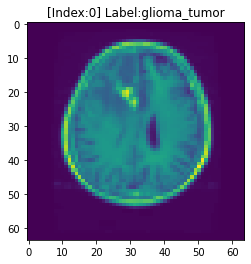

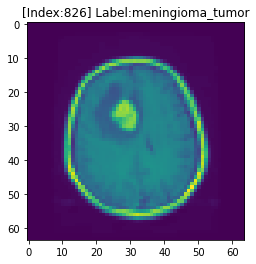

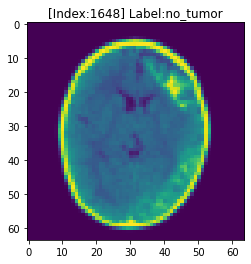

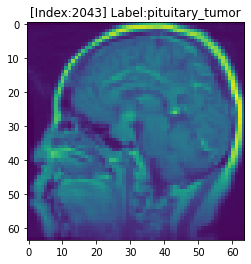

In [4]:
j = 0
for i in range(len(y)):
    if y[i] in labels[j]:
        plt.imshow(images[i])
        plt.title("[Index:{}] Label:{}".format(i, y[i]))
        plt.show()
        j += 1
    if j >= len(labels):
        break

In [159]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

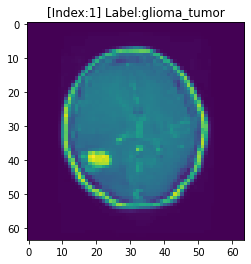

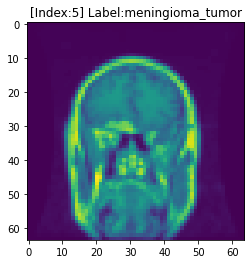

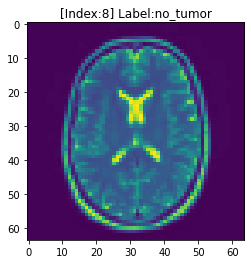

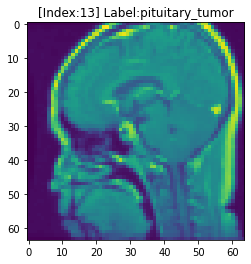

In [8]:
ximages = X_train.reshape(-1,image_size,image_size)
j = 0
for i in range(len(y_train)):
    if y_train[i] in labels[j]:
        plt.imshow(ximages[i])
        plt.title("[Index:{}] Label:{}".format(i, y_train[i]))
        plt.show()
        j += 1
    if j >= len(labels):
        break

# Augmentation

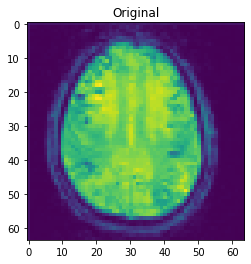

In [62]:
plt.imshow(X_train[y_train=='no_tumor'].reshape(-1,image_size,image_size)[0])
plt.title("Original")
plt.show()

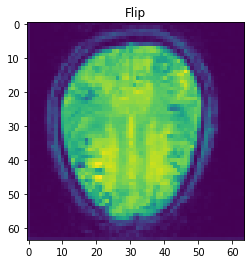

In [63]:
x_aug = X_train[y_train=='no_tumor'].reshape(-1,image_size,image_size)[:,::-1, :]
y_aug =y_train[y_train=='no_tumor']
plt.imshow(x_aug[0])
plt.title("Flip")
plt.show()

In [64]:
X_train = np.vstack((X_train,x_aug.reshape(-1,image_size*image_size)))
y_train = np.hstack((y_train,y_aug))

In [66]:
print(X_train.shape, y_train.shape)

(2297, 4096) (2297,)


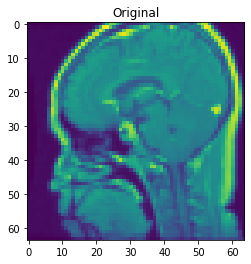

In [65]:
plt.imshow(X_train[13].reshape(image_size,image_size))
plt.title("Original")
plt.show()

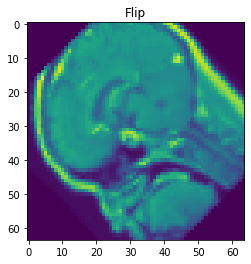

In [67]:
from skimage.transform import rotate

# perform a 45 degree rotation
x_aug = []
for i in range(X_train.shape[0]):
    x_aug.append(rotate(X_train[i].reshape(image_size,image_size), 45))
plt.imshow(x_aug[13])
plt.title("Flip")
plt.show()

In [68]:
X_train = np.vstack((X_train,np.array(x_aug).reshape(-1,image_size*image_size)))
y_train = np.hstack((y_train,y_train))

In [69]:
print(X_train.shape, y_train.shape)

(4594, 4096) (4594,)


# Classification with Scikit Learn Library (Programming Assignment)
### Variable Explanation (Do not change variable names)
- 'X_train' is feature vectors of training dataset
- 'y_train' is target labels of training dataset
- 'X_test' is feature vectors of test dataset
- 'y_test' is target labels of test dataset
- 'y_pred' was initialized as zero vectors and fill 'y_pred' with predicted labels

### Find the best model and hyperparameter for face recognition

In [81]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CNN
0.818815331010453

In [ ]:
from sklearn.preprocessing import OneHotEncoder
oe = OneHotEncoder()
oe.fit(y_train.reshape(-1,1))
y_train_onehot = oe.transform(y_train.reshape(-1,1)).toarray()
y_test_onehot = oe.transform(y_test.reshape(-1,1)).toarray()

In [ ]:
from collections import OrderedDict
import copy

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx


class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='Adam', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: 
                print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [ ]:
class SimpleConvNet:
    """
    다음과 같은 CNN을 구성한다.
    → Conv → ReLU → Pooling → Affine → ReLU → Affine → Softmax →
    전체 구현은 simple_convnet.py 참고
    """
    def __init__(self, input_dim=(1, image_size, image_size),
                 conv_param={'filter_num': 30, 'filter_size': 7,
                             'pad': 1, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        # 초기화 인수로 주어진 하이퍼파라미터를 딕셔너리에서 꺼내고 출력 크기를 계산한다.
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / \
            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) *
                               (conv_output_size/2))

        # 1층의 합성곱 계층과 2, 3층의 완전연결 계층의 가중치와 편향 생성
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # CNN을 구성하는 계층을 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        """추론을 수행"""
        for layer in list(self.layers.values()):
            x = layer.forward(x)
        return x

    def extract_feature(self, x):
        """추론을 수행"""
        features = copy.deepcopy(self.layers)
        del features['Affine1']
        del features['Relu2']
        del features['Affine2']
        #for layer in [network.layers['Conv1'],network.layers['Relu1'], network.layers['Pool1']]:
        for layer in list(features.values()):
            x = layer.forward(x)
            return x

    def loss(self, x, t):
        """손실함수 값 계산"""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        """오차역전파법으로 기울기를 구함"""
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

# 본 신경망으로 실제 MNIST 데이터셋을 학습하는 코드는 train_convnet.py 참고


# 데이터 읽기
(x_train, t_train), (x_test, t_test) = (X_train.reshape(-1, 1, 64, 64), y_train_onehot), (X_test.reshape(-1, 1, 64, 64), y_test_onehot)

max_epochs = 50

network = SimpleConvNet(input_dim=(1, image_size, image_size),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=4, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:1.3828416835220028
=== epoch:1, train acc:0.27, test acc:0.2682926829268293 ===
train loss:1.3774184376440375
train loss:1.372938099996426
train loss:1.3601280693247093
train loss:1.3326669624458696
train loss:1.3436047258848496
train loss:1.3441814314951919
train loss:1.2752502066248703
train loss:1.2931017045375959
train loss:1.2537823465207305
train loss:1.2768138540279752
train loss:1.229268351876972
train loss:1.153565437840198
train loss:1.2354073828743979
train loss:1.2016613392242024
train loss:1.1665052518503678
train loss:1.2040383108599495
train loss:1.0951656714858817
train loss:1.190942802735752
train loss:1.15626207707071
train loss:1.1879463659083298
train loss:1.204793728380782
train loss:1.100024163481378
train loss:1.0609821935131132
train loss:1.197971336960622
train loss:1.1433539966065434
train loss:1.115834439619844
train loss:1.0965537602309197
train loss:1.0950438963443783
train loss:1.0659386263023638
train loss:1.0543267282618118
train loss:1.056355

KeyboardInterrupt: ignored

In [ ]:
x_train = network.extract_feature(x_train)
x_train = x_train.reshape(x_train.shape[0],-1)
t_train = np.argmax(t_train, axis=-1)
x_test = network.extract_feature(x_test)
x_test = x_test.reshape(x_test.shape[0],-1)
t_test = np.argmax(t_test, axis=-1)

In [ ]:
t_test

In [ ]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
t_train = scaler.transform(t_train)

ValueError: ignored

In [ ]:
X_train = x_train
y_train = t_train
X_test = x_test
y_test = t_test

# Test set (지울것)

In [168]:
_images = []
y_master = []
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/final_project/Testing',i)
    for j in os.listdir(folderPath):
        img = skimage.io.imread(os.path.join(folderPath,j),)
        img = skimage.transform.resize(img,(image_size,image_size))
        img = skimage.color.rgb2gray(img)
        _images.append(img)
        y_master.append(i)
        
_images = np.array(_images)

X_master = _images.reshape((-1, image_size**2))
X_master_scaled = scaler.transform(X_master)
y_master = np.array(y_master)

# Machine Learning

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score

# RandomForestClassifier

In [79]:
params_rfc = {
    'random_state':0,
    'max_depth':18,
    'criterion':'entropy',
    'n_estimators': 250,
    'n_jobs':-1
}

In [82]:
model = RandomForestClassifier(**params_rfc)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.897793


In [83]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

Accuracy: 0.621827


# SGDClassifier

# KNeighborsClassifier

In [87]:
params_knn = {
    'n_neighbors': 1,
    'p': 1,
    'metric': 'manhattan',
    'weights': 'uniform',
    'n_jobs': -1
}

In [88]:
model = KNeighborsClassifier(**params_knn)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))
# 'max_iter': 350

Accuracy: 0.907085


In [89]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

Accuracy: 0.690355


# AdaBoostClassifier

In [ ]:
model = SVC(**params_svm)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))
# 'max_iter': 350

In [ ]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

# HistGradientBoostingClassifier
0.900116

In [160]:
params_hgb = {
    'random_state': 0, # 0
    'learning_rate': 0.1, # 0.1
    'max_iter': 100, # 200
    'max_depth': 16, # 16 631980
    'l2_regularization': 0, #0 
    'tol': 1e-7 # 1e-7
}

In [170]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html
model = HistGradientBoostingClassifier(**params_hgb)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.890825


In [179]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

Accuracy: 0.631980


# SVC
0.891986

In [220]:
params_svm = {
    'random_state': 0,
    'C': 5.0,
    'kernel': 'rbf',
    'gamma': 'scale', #0.0005 / 0.891986
    'shrinking': True,
    'probability': True,
    'tol':1e-3,
    'class_weight': 'balanced',
    'max_iter': 350,
    'break_ties': True
}

In [ ]:
model = SVC(**params_svm)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))
# 'max_iter': 350

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=350).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.882695


In [ ]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

Accuracy: 0.611675


# LogisticRegression

In [ ]:
model = SVC(**params_svm)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))
# 'max_iter': 350

In [ ]:
y_pred=model.predict(X_master)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

# DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier(**params_svm)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))
# 'max_iter': 350

In [ ]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

# ExtraTreesClassifier

In [216]:
params_etc = {
    'random_state': 0,
    'n_estimators': 500,
    'max_depth': 16,
    'min_samples_split': 2,
    'min_samples_leaf': 3
}#0.634518

In [217]:
model = ExtraTreesClassifier(**params_etc)
model.fit(X_train_scaled, y_train)
y_pred=model.predict(X_test_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.898955


In [218]:
y_pred=model.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

Accuracy: 0.634518


# Ensemble
0.924506387921022

In [223]:
# 개별 모델을 정의해주어야 한다
rfc_clf = RandomForestClassifier(**params_rfc)
knn_clf = KNeighborsClassifier(**params_knn)
svc_clf = SVC(**params_svm)
hgb_clf = HistGradientBoostingClassifier(**params_hgb)
etc_clf = ExtraTreesClassifier(**params_etc)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기(기본값은 하드보팅방식)
# 개별 모델을 estimators라는 리스트 인자에다가 (key, value) 튜플 형태로 넣어주기
vo_clf = VotingClassifier(estimators=[
                                      ('knn', knn_clf),
                                
                                      ('hgb', hgb_clf),
                                      ('etc', etc_clf)])
'''vo_clf = VotingClassifier(estimators=[('RFC', rfc_clf),
                                      ('KNN', knn_clf),
                                      ('svc', svc_clf)],
                         voting='soft')'''

# Voting분류기 학습
vo_clf.fit(X_train_scaled, y_train)
pred_y = vo_clf.predict(X_test_scaled)
print('Voting 분류기 정확도', accuracy_score(y_test, pred_y))

Voting 분류기 정확도 0.9152148664343787


In [224]:
y_pred=vo_clf.predict(X_master_scaled)
print('Accuracy: %f' % sklearn.metrics.accuracy_score(y_master, y_pred))

Accuracy: 0.675127


# Model

In [ ]:
# https://blog.mattbowers.dev/xgboost-from-scratch
#TODO
#1. Create a classification object in scikit learn package (such as perceptron, logistic regression, or other classification algorithms)
#2. Fit the object to training dataset
#3. Predict the label of test data point (X_test)
# - Do not change the variable name "y_pred"

y_pred = np.zeros_like(y_test)

### Print accuracy (do not modify the following block)

In [ ]:
print('Accuracy: %.2f' % sklearn.metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.00
